# TP4 :  Learning on a low budget
**Théo Rudkiewicz, Cyriaque Rousselot**

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data samples are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ exists but is not accessible. 
(To make your task easier, we provide you with some data (named `test_dataset` in the code) that you can use to test your model, but you **must not** use it to train your model).

We also assume that we have a limited computational budget.

The goal of this practical session is to guide you through different methods that will help you get better results from few resources (data & compute).

In this practical, we will use the `resnet18` architecture. We will use models from the [pytorch vision hub ](https://pytorch.org/vision/stable/models.html#).

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide 7 files : 
1. This Notebook
2. `utils.py`
3. `last_layer_finetune.pth` (the file **must be of size less than 5Mo**)
4. `daug_resnet.pth` (the file **must be of size less than 50Mo**)
5. `final_model.pth` (the file **must be of size less than 50Mo**)
6. `drawing_lora.png`
7. `cutmix.png`

If the code you defined passes all our tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear and short answers between `<div class="alert alert-info">  <your answer>  </div>` tags (when it's not code).  

<div class="alert alert-info">  Example of answer  </div>

In [4]:
import os

if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP4_images"):
    os.mkdir("data/TP4_images")
    !cd data/TP4_images && wget -O north_dataset_train.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/yzQRWE2YjmFn9WA/download/north_dataset_train.zip" && unzip north_dataset_train.zip
    !cd data/TP4_images && wget -O north_dataset_test.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/zntidWrFdYsGMDm/download/north_dataset_test.zip" && unzip north_dataset_test.zip

In [5]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchmetrics.classification import BinaryAccuracy, Accuracy, ConfusionMatrix

dir_path = "data/TP4_images/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_test",
    transform=transforms.Compose([transforms.ToTensor()]),
)
base_model = models.resnet18()

## Question 1 : 
>  Change the last layer of the resnet model so that its size fits the problem. 

In [6]:
# Hint 
base_model.fc = nn.Linear(512, 2)
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
assert (
    base_model.fc.out_features == 2
)  # we could also change the last layer to have 1 output. Do it with 2 so that it matches our tests procedure during grading.

## Question 2: 
> Train the last layer of a randomly initialized resnet model. Provide a function precompute_features in `utils.py` that creates a new dataset from the features precomputed by the model.

Intermediate question :  Provide the training process in the notebook with training curve. Comment on the accuracy. 

In [8]:
from copy import deepcopy
from torch.utils.data import DataLoader

def precompute_features(
    model: models.ResNet, 
    dataset: torch.utils.data.Dataset, 
    device: torch.device
) -> torch.utils.data.Dataset:
    """
    Create a new dataset with the features precomputed by the model.

    If the model is $f \circ g$ where $f$ is the last layer and $g$ is 
    the rest of the model, it is not necessary to recompute $g(x)$ at 
    each epoch as $g$ is fixed. Hence you can precompute $g(x)$ and 
    create a new dataset 
    $\mathcal{X}_{\text{train}}' = \{(g(x_n),y_n)\}_{n\leq N_{\text{train}}}$

    Arguments:
    ----------
    model: models.ResNet
        The model used to precompute the features
    dataset: torch.utils.data.Dataset
        The dataset to precompute the features from
    device: torch.device
        The device to use for the computation
    
    Returns:
    --------
    torch.utils.data.Dataset
        The new dataset with the features precomputed
    """
    # dataset is small so we can use a single batch
    dataloader = DataLoader(dataset, batch_size=len(dataset))
    model.to(device)

    data = next(iter(dataloader))[0]
    features = model(data)
    targets = next(iter(dataloader))[1] 

    features_dataset = torch.utils.data.TensorDataset(features, targets)

    return features_dataset

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/var/folders/_y/2rw4wkns73v1mc9wlr3l0k_h0000gn/T/ipykernel_27946/692256572.py:9: SyntaxWarning: invalid escape sequence '\c'
  """


In [9]:
import utils
import importlib
importlib.reload(utils)
from utils import precompute_features

features_model = deepcopy(base_model)
features_model.fc = nn.Identity()

features_dataset = precompute_features(features_model, north_dataset, device)
features_dataloader = DataLoader(features_dataset, batch_size=16, shuffle=True)

test_features_dataset = precompute_features(features_model, test_dataset, device)
test_features_dataloader = DataLoader(test_features_dataset, batch_size=16)

last_layer = nn.Sequential(nn.Linear(512, 2))

print(last_layer(features_dataset[0][0]))
last_layer(features_dataset[0][0].unsqueeze(0))

n_epochs = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(last_layer.parameters(), lr=1e-3)


def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, n_epochs):
    train_loss_history = []
    test_loss_history = []
    accuracy_history = []

    for i in range(n_epochs):
        model.train()
        train_loss = 0
        test_loss = 0
        correct = 0
        for features, targets in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(features)
            loss = loss_fn(y_pred, targets)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        with torch.no_grad():
            model.eval()
            for features, targets in test_dataloader:
                y_pred = model(features)
                loss = loss_fn(y_pred, targets)
                test_loss += loss.item()
                correct += (torch.argmax(y_pred, dim=1) == targets).sum()

        accuracy = correct/len(test_dataloader.dataset)
        
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        accuracy_history.append(accuracy)
        
        if i%100 == 0:
            print(f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, accuracy: {accuracy:.4f}") 
        
    return train_loss_history, test_loss_history, accuracy_history

train_loss_history, test_loss_history, accuracy_history = train(last_layer, features_dataloader, test_features_dataloader, loss_fn, optimizer, n_epochs)

/Users/matthieuneau/Desktop/Centrale/DLP/practice-labs/utils.py:12: SyntaxWarning: invalid escape sequence '\c'
  """


tensor([0.0488, 0.2123], grad_fn=<ViewBackward0>)
Epoch 1, train loss: 1.8919, test loss: 3.7445, accuracy: 0.5000


In [10]:
import matplotlib.pyplot as plt

def plot_training(train_loss_history, test_loss_history, accuracy_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_loss_history, label='Train Loss')
    ax1.plot(test_loss_history, label='Test Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Train and Test Loss over Epochs')
    ax1.legend()

    ax2.plot(accuracy_history, label='Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy over Epochs')
    ax2.legend()

    plt.show()

<div class="alert alert-info">  We can see that the test loss increases over time because the model gets more and more confident in its predictions, which can be checked by inspecting the logits. Nonetheless, the accuracy over the test set keeps increasing so the model is not overfitting  </div>

## Question 3 : 
> Now start from a pretained model on Imagenet (https://pytorch.org/vision/stable/models.html#) and only train the last layer. Provide the training process in the notebook with training curve. 

 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `utils.py` containing only the last layer class `LastLayer` inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `last_layer_finetune.pth` file containing __only the last layer weights__ ( we will check the size) 
 
 We will test your model on final accuracy on a test set. 
 

Using cache found in /Users/matthieuneau/.cache/torch/hub/pytorch_vision_main


Epoch 1, train loss: 1.8739, test loss: 3.1773, accuracy: 0.5000
False


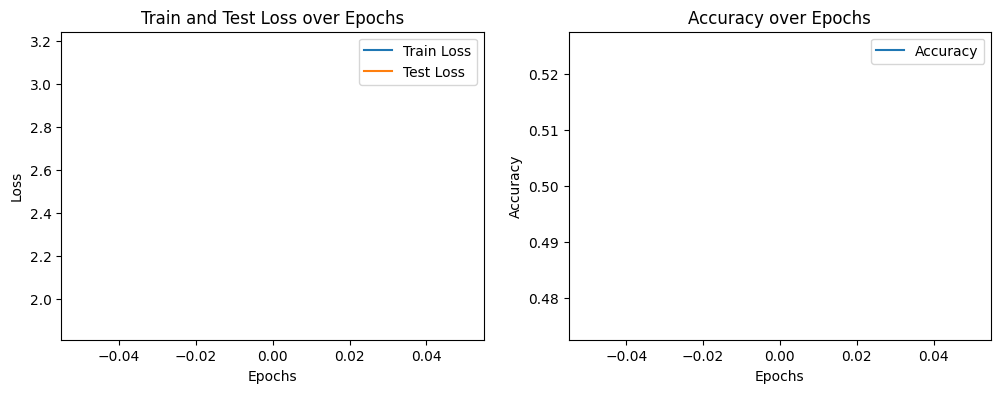

In [38]:
pretrained_model = torch.hub.load("pytorch/vision", "resnet18", weights="IMAGENET1K_V1")

for param in pretrained_model.parameters():
    param.requires_grad = False

pretrained_model.fc = nn.Linear(512, 2)
pretrained_model.fc.requires_grad_=True

# print(pretrained_model.fc)
old_weights = pretrained_model.conv1.weight.data.clone()
old_fc = pretrained_model.fc.weight.data.clone()

train_dataloader = DataLoader(north_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=1e-3)

n_epochs = 1
train_loss_history, test_loss_history, accuracy_history = train(pretrained_model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, n_epochs=n_epochs)

new_weights = pretrained_model.conv1.weight.data.clone()
new_fc = pretrained_model.fc.weight.data.clone()

assert torch.allclose(old_weights, new_weights, atol=1e-2), "The weights of the pretrained model have been modified"
print(torch.allclose(old_fc, new_fc))

plot_training(train_loss_history, test_loss_history, accuracy_history)

# torch.save(base_model.fc.state_dict(), "lastlayer.pth")

In [12]:
from utils import LastLayer
import importlib
importlib.reload(utils)

resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()  # !  Important : No argument

state_dict = torch.load("lastlayer.pth", weights_only=True)
renamed_state_dict = {'linear.' + k:v for k,v in state_dict.items()}    # to avoid name mismatch when loading the state_dict

fc.load_state_dict(renamed_state_dict)
resnet.fc = fc
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Question 4 : 
> Perform  LoRA https://arxiv.org/pdf/2106.09685  on the model  (We are perfectly fine if you use an external library **for this question only**, and of course use it in the next questions). (Warning : without data augmentation it may not improve the accuracy.)

Intermediate question : Describe LoRA. There are different ways of implementing LoRa for convolutions. You can choose your preferred one. Explain the version of LoRa you used, provide a drawing of the process in the `drawing_lora.png` file. (Hint: you can obtain a small rank convolution by combining a convolution and a 1x1 convolution. One of the two goes from a higher number of channels to a lower number of channels and the other one restores the number of channels.)

In [40]:
train_dataloader.dataset[0][0]

tensor([[[0.5922, 0.6000, 0.6157,  ..., 0.8314, 0.8431, 0.8549],
         [0.6078, 0.6118, 0.6157,  ..., 0.8314, 0.8431, 0.8510],
         [0.6196, 0.6196, 0.6157,  ..., 0.8314, 0.8431, 0.8549],
         ...,
         [0.2706, 0.2980, 0.3412,  ..., 0.2431, 0.2000, 0.2000],
         [0.2196, 0.3216, 0.3608,  ..., 0.2000, 0.2157, 0.1569],
         [0.1373, 0.2902, 0.3333,  ..., 0.1843, 0.1804, 0.1882]],

        [[0.6980, 0.7059, 0.7216,  ..., 0.8392, 0.8510, 0.8627],
         [0.7137, 0.7176, 0.7216,  ..., 0.8392, 0.8510, 0.8588],
         [0.7255, 0.7255, 0.7216,  ..., 0.8471, 0.8510, 0.8627],
         ...,
         [0.3373, 0.3647, 0.3961,  ..., 0.2431, 0.2000, 0.2000],
         [0.2863, 0.3922, 0.4196,  ..., 0.2000, 0.2157, 0.1569],
         [0.2078, 0.3608, 0.3922,  ..., 0.1843, 0.1804, 0.1882]],

        [[0.8745, 0.8824, 0.8980,  ..., 0.8863, 0.8980, 0.9098],
         [0.8902, 0.8941, 0.8980,  ..., 0.8863, 0.8980, 0.9059],
         [0.8941, 0.8941, 0.8902,  ..., 0.8902, 0.8980, 0.

In [ ]:
#TODO: Don't forget to scale the LORA
# from lora import ConvLora
resnet = models.resnet18(weights="DEFAULT")

layer = resnet.layer1[0].conv1
lora_layer = ConvLora(layer.in_channels, layer.out_channels, layer.requires_grad_(False), alpha=10, r=2)

resnet.layer1[0].conv1 = lora_layer

old_weights = resnet.layer1[0].conv1.frozen_conv.weight.data.clone()
old_weights2 = resnet.layer1[0].conv1.downConv.weight.data.clone()

n_epochs=1
train(resnet, train_dataloader, test_dataloader, loss_fn, optimizer, n_epochs)

new_weights = resnet.layer1[0].conv1.frozen_conv.weight.data.clone()
new_weights2 = resnet.layer1[0].conv1.downConv.weight.data.clone()

torch.allclose(old_weights, new_weights )
torch.allclose(old_weights2, new_weights2)

# resnet(train_dataloader.dataset[0][0].unsqueeze(0))
# print(resnet.layer1[0].conv1.frozen_weight)

# print(resnet)

# torch.save(lora_model.state_dict(), "lora_resnet.pth")

Epoch 1, train loss: 26.0586, test loss: 41.6306, accuracy: 0.0000


True

In [50]:
# for now, only handle 3x3 conv with padding=stride=1
import torch.nn as nn


class ConvLora(nn.Module):
    def __init__(self, in_channels, out_channels, frozen_conv, r=2, alpha=2):
        super().__init__()
        self.alpha = alpha
        self.r = r
        self.downConv = nn.Conv2d(in_channels, r, kernel_size=3, padding=1, stride=1)
        self.upConv = nn.Conv2d(r, out_channels, kernel_size=1, padding=0, stride=1)
        self.frozen_conv = frozen_conv
        
    def forward(self, x):
        main_x = self.frozen_conv(x) 
        lora_x = self.downConv(x)
        lora_x = self.upConv(lora_x)
        return main_x + (self.alpha/self.r)*lora_x

## Question 5 : 
In order to better train our LORA weights, let's do some Data Augmentation https://en.wikipedia.org/wiki/Data_augmentation . Load some alteration of the data from the `torchvision.transforms` module and incorporate them in your training pipeline.

 Intermediate question : Check CutMix  (https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py) and explain it with a small drawing `cutmix.png`. 


  Provide one file : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a `daug_resnet.pth` file containing the weight of the ResNet18 after DAUG  (  !  It  has to be of the class ResNet so you have to merge LoRA weights with the ResNet18 weights)

In [ ]:
## Data Augmentation
from torchvision.transforms import v2

In [ ]:
lora_model = NotImplementedError  # <YOUR CODE>
assert isinstance(lora_model, models.ResNet)

In [ ]:
torch.save(lora_model.state_dict(), "daug_resnet.pth")

## Question 6 : (BONUS) 
> Do the best you can : improve performance on test set while keeping ResNet 18 architecture, or decrease the size of the model

Provide a file  `final_model.pth` containing the weights of the final model and provide the class `FinalModel()` in the `utils.py` file. 